# Latent Dirichlet Allocation

In this section of the tutorial, we will investigate the use of Latent Dirichlet Allocation for Topic Modelling in `sklearn`. Latent Dirichlet Allocation mainly rely on `fit(X)` and `transform(X)` methods. These two actions can be performed sequentially _via_ a single call to the `fit_transform(X)` method. Once fitted, components are stored in decreasing importance order in the `components_` attribute.

More information about the use of Latent Dirichlet Allocation in `sklearn` can be found at: <http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html>.

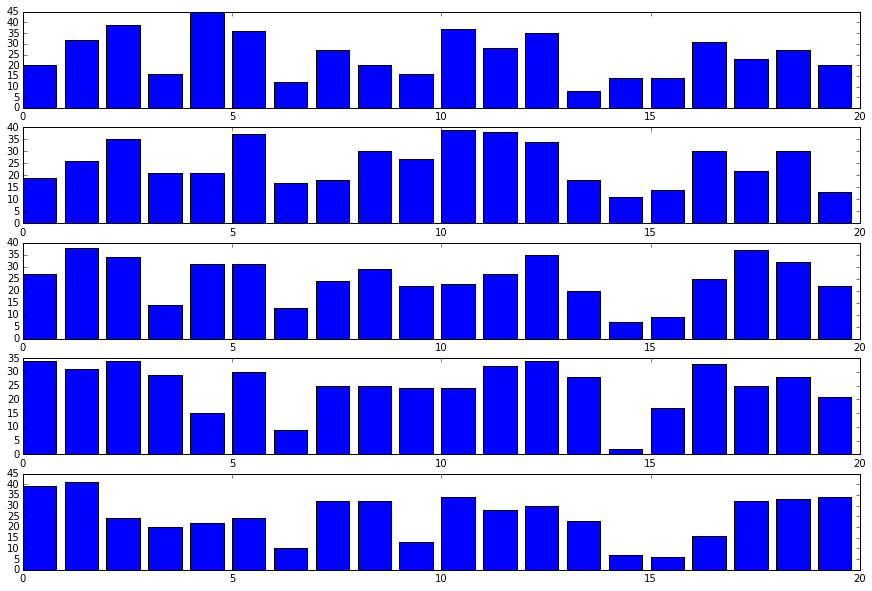

In [1]:
%matplotlib inline

from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

n_words = 20
n_topics = 3
n_docs = 1000
n_terms_per_doc = 500

np.random.seed(0)
p_word_in_topic = np.random.rand(n_topics, n_words)
# Make sure that for each topic, word probas sum to 1
p_word_in_topic /= np.sum(p_word_in_topic, axis=1).reshape((n_topics, 1))

p_topic_in_doc = np.random.rand(n_docs, n_topics)
# Make sure that for each doc, topic probas sum to 1
p_topic_in_doc /= np.sum(p_topic_in_doc, axis=1).reshape((n_docs, 1))

word_counts = np.zeros((n_docs, n_words))
for doc in range(n_docs):
    for word in range(n_terms_per_doc):
        # Pick a topic at random according to drawn document-specific probas
        topic = np.random.choice(np.arange(n_topics), p=p_topic_in_doc[doc])
        # Pick a term at random according to drawn topic-specific probas
        term = np.random.choice(np.arange(n_words), p=p_word_in_topic[topic])
        # Update counts
        word_counts[doc, term] += 1

n_docs_shown = 5
plt.figure(figsize=(15, 2 * n_docs_shown))
for doc in range(n_docs_shown):
    plt.subplot(n_docs_shown, 1, doc + 1)
    plt.bar(np.arange(n_words), word_counts[doc, :])

Let us now fit a LDA model to this term-document matrix and see if our probas are well-estimated:

In [2]:
lda = LatentDirichletAllocation(n_topics=3, learning_method="batch")
lda.fit(word_counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=3, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

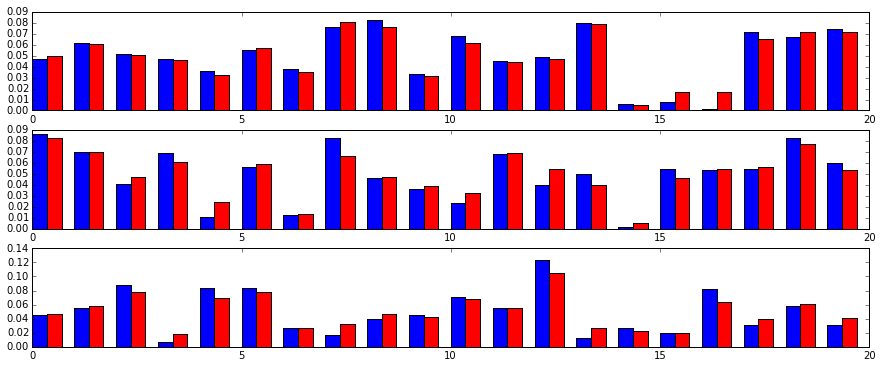

In [3]:
def best_permutation_3topics(m1, m2):
    all_permutations = [[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]]
    distances = [np.linalg.norm(m1 - m2[perm]) for perm in all_permutations]
    return all_permutations[np.argmin(distances)]
    

estimated_p_word_in_topic = lda.components_ 
estimated_p_word_in_topic /= np.sum(lda.components_, axis=1).reshape((n_topics, 1))

# Reorder topic ids
perm = best_permutation_3topics(p_word_in_topic, estimated_p_word_in_topic)
estimated_p_word_in_topic = estimated_p_word_in_topic[perm]

w = 0.35
plt.figure(figsize=(15, 2 * n_topics))
for topic in range(n_topics):
    plt.subplot(n_topics, 1, topic + 1)
    plt.bar(np.arange(n_words), p_word_in_topic[topic, :], w, color="b")
    plt.bar(np.arange(n_words) + w, estimated_p_word_in_topic[topic, :], w, color="r")

In [4]:
n_best = 5
for topic in range(n_topics):
    sorted_words = np.argsort(estimated_p_word_in_topic[topic, :])
    print("Top %d words in learnt topic #%d" % (n_best, topic))
    for word_rank in range(n_best):
        word = sorted_words[- word_rank - 1]
        print("p(w=%02d|z=%d)=%.3f" % (word, topic, estimated_p_word_in_topic[topic, word]))

Top 5 words in learnt topic #0
p(w=07|z=0)=0.081
p(w=13|z=0)=0.079
p(w=08|z=0)=0.077
p(w=19|z=0)=0.072
p(w=18|z=0)=0.071
Top 5 words in learnt topic #1
p(w=00|z=1)=0.083
p(w=18|z=1)=0.077
p(w=01|z=1)=0.070
p(w=11|z=1)=0.069
p(w=07|z=1)=0.067
Top 5 words in learnt topic #2
p(w=12|z=2)=0.105
p(w=02|z=2)=0.078
p(w=05|z=2)=0.078
p(w=04|z=2)=0.069
p(w=10|z=2)=0.068
